In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from shapely.geometry import Point
import json
from shapely.geometry import shape

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1)  Soil Moisture Data

In [ ]:
soil_moisture = pd.read_csv('/content/drive/My Drive/Sentinel1_Derived_SoilMoisture_Uttarakhand_2024.csv')
soil_moisture.head()

system:index        date  \
0  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239...  2024-01-02   
1  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239...  2024-01-02   
2  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239...  2024-01-02   
3  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239...  2024-01-02   
4  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239...  2024-01-02   

   soil_moisture                                               .geo  
0     -11.933647  {"geodesic":false,"type":"Point","coordinates"...  
1     -13.786270  {"geodesic":false,"type":"Point","coordinates"...  
2     -13.974002  {"geodesic":false,"type":"Point","coordinates"...  
3     -13.385861  {"geodesic":false,"type":"Point","coordinates"...  
4     -14.568831  {"geodesic":false,"type":"Point","coordinates"...

In [ ]:
print(soil_moisture.shape)

(3761426, 4)


In [ ]:
print(soil_moisture.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761426 entries, 0 to 3761425
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   system:index   object 
 1   date           object 
 2   soil_moisture  float64
 3   .geo           object 
dtypes: float64(1), object(3)
memory usage: 114.8+ MB
None


In [ ]:
print(soil_moisture.describe())

       soil_moisture
count   3.761426e+06
mean   -1.051746e+01
std     4.012878e+00
min    -3.241062e+01
25%    -1.309311e+01
50%    -1.095064e+01
75%    -8.146368e+00
max     9.374024e+00


In [ ]:
print(soil_moisture.isnull().sum())

system:index     0
date             0
soil_moisture    0
.geo             0
dtype: int64


In [ ]:
# Convert 'date' to datetime format
soil_moisture['date'] = pd.to_datetime(soil_moisture['date'])

In [ ]:
soil_moisture['date'].dt.year.unique()

array([2024], dtype=int32)

#### 1) Active fire points datasets

In [ ]:
fire_points = pd.read_csv('/content/drive/My Drive/filtered_active_fire_data_uttarakhand.csv')
fire_points.head()

latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  30.47758   79.40485      304.26  0.46   0.39  2023-01-01      2014   
1  28.95413   79.75963      329.74  0.49   0.40  2023-01-02       731   
2  29.16875   79.09808      329.08  0.52   0.41  2023-01-02       731   
3  29.93845   80.53337      339.87  0.44   0.38  2023-01-02       731   
4  29.93838   80.53476      330.97  0.44   0.38  2023-01-02       731   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  \
0         N      VIIRS          n        2      274.73  0.71        N     0   
1         N      VIIRS          n        2      293.31  3.37        D     0   
2         N      VIIRS          n        2      291.75  4.12        D     0   
3         N      VIIRS          n        2      297.83  5.48        D     0   
4         N      VIIRS          n        2      294.74  3.52        D     0   

         STATE  State_LGD    Shape_Leng    Shape_Area  
0  UTTAR>KHAND          5  1.660954e+06  5.196449e+10  
1  UTTAR>KHAND          5  1.660954e+06  5.196449e+10  
2  UTTAR>KHAND          5  1.660954e+06  5.196449e+10  
3  UTTAR>KHAND          5  1.660954e+06  5.196449e+10  
4  UTTAR>KHAND          5  1.660954e+06  5.196449e+10

In [ ]:
fire_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186714 entries, 0 to 186713
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    186714 non-null  float64
 1   longitude   186714 non-null  float64
 2   bright_ti4  186714 non-null  float64
 3   scan        186714 non-null  float64
 4   track       186714 non-null  float64
 5   acq_date    186714 non-null  object 
 6   acq_time    186714 non-null  int64  
 7   satellite   186714 non-null  object 
 8   instrument  186714 non-null  object 
 9   confidence  186714 non-null  object 
 10  version     186714 non-null  int64  
 11  bright_ti5  186714 non-null  float64
 12  frp         186714 non-null  float64
 13  daynight    186714 non-null  object 
 14  type        186714 non-null  int64  
 15  STATE       186714 non-null  object 
 16  State_LGD   186714 non-null  int64  
 17  Shape_Leng  186714 non-null  float64
 18  Shape_Area  186714 non-null  float64
dtypes:

#### 2)  Data Analysis

###### Soil Moisture distribution

<Axes: xlabel='soil_moisture', ylabel='Count'>

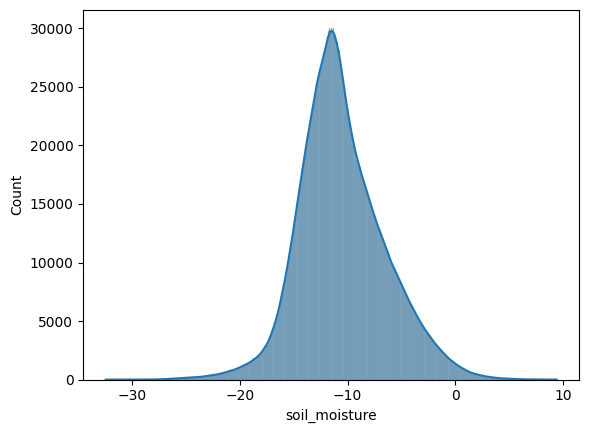

In [ ]:
sns.histplot(soil_moisture['soil_moisture'], kde=True)

**Key Observations:**

*Skewness:* The soil moisture distribution is slightly left-skewed, with a peak around -10 to -11. Most values are concentrated in this range.

*Spread:* There are a few extreme values on the lower side (e.g., below -20), indicating outliers or rare conditions.

*Insights:* The histogram confirms that the soil moisture data is mostly clustered around a specific range with a gradual decline on both sides, suggesting a stable soil moisture regime in most cases.

###### Soil Moisture trends over time

<Axes: title={'center': 'Average Soil Moisture Over Time'}, xlabel='date', ylabel='Soil Moisture'>

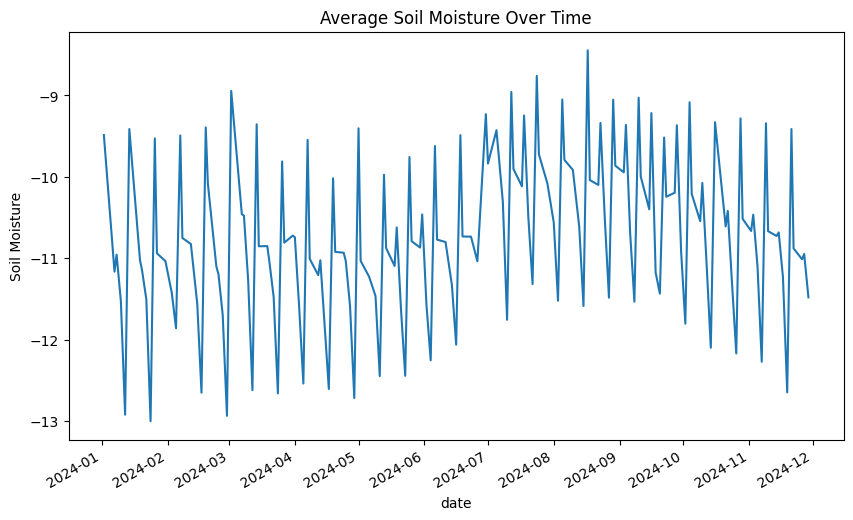

In [ ]:
time_series = soil_moisture.groupby('date')['soil_moisture'].mean()
time_series.plot(kind='line', title='Average Soil Moisture Over Time', ylabel='Soil Moisture', figsize=(10, 6))

**Key Observation:** The soil moisture levels fluctuate over time, showing a cyclical or seasonal trend. There's a notable increase from June to August, likely due to the rainy season.

*Range:* Soil moisture values hover between approximately -9 and -13. The overall trend appears relatively consistent, with no significant long-term increase or decrease.

#### 3) Soil Moisture and Fire Points Analysis

Monthly soil moisture

In [ ]:
# Extract month for grouping
soil_moisture['month'] = soil_moisture['date'].dt.to_period('M')

# Group by month and calculate the average soil moisture for each month
monthly_soil_moisture = soil_moisture.groupby('month')['soil_moisture'].mean().reset_index()

Monthly Fire Points

In [ ]:
# Convert 'acq_date' to datetime format
fire_points['acq_date'] = pd.to_datetime(fire_points['acq_date'])

# Extract month as a period for grouping (to match soil_moisture['month'])
fire_points['month'] = fire_points['acq_date'].dt.to_period('M')

# Group by month and count fire points per month
monthly_fire_counts = fire_points.groupby(['month']).size().reset_index(name='fire_point_count')

Correlation Analysis

In [ ]:
# Merge the two datasets on the 'month' column
merged_data = pd.merge(monthly_soil_moisture, monthly_fire_counts, on='month')

# Calculate the Pearson correlation coefficient
correlation, _ = pearsonr(merged_data['soil_moisture'], merged_data['fire_point_count'])

# Print the correlation
print(f"Pearson correlation coefficient: {correlation}")

Pearson correlation coefficient: -0.7566097362963153


**Key Observation:** The Pearson correlation coefficient of -0.7566 indicates a moderate to strong negative correlation: As soil moisture decreases, the number of fire points increases.

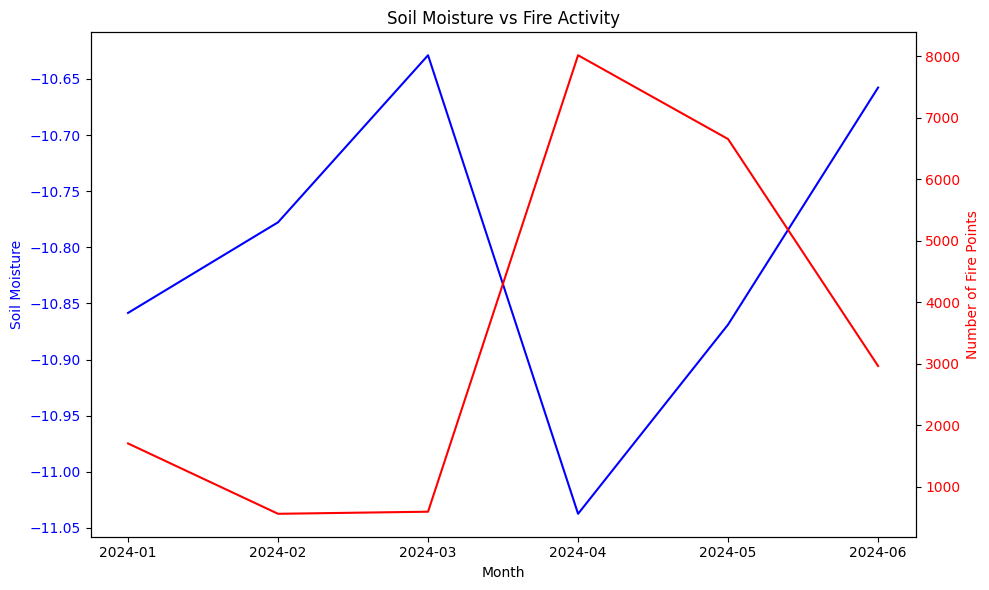

In [ ]:
# Create a plot with two subplots: one for soil moisture and one for fire counts
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot soil moisture
ax1.plot(merged_data['month'].astype(str), merged_data['soil_moisture'], color='blue', label='Soil Moisture')
ax1.set_xlabel('Month')
ax1.set_ylabel('Soil Moisture', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot fire counts
ax2 = ax1.twinx()
ax2.plot(merged_data['month'].astype(str), merged_data['fire_point_count'], color='red', label='Fire Points')
ax2.set_ylabel('Number of Fire Points', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and layout
plt.title('Soil Moisture vs Fire Activity')
plt.tight_layout()
plt.show()


For better Visualization: Monthly soil moisture and fire points

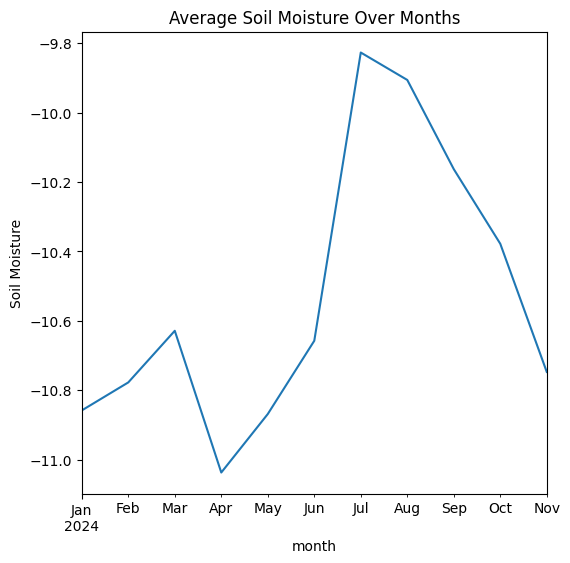

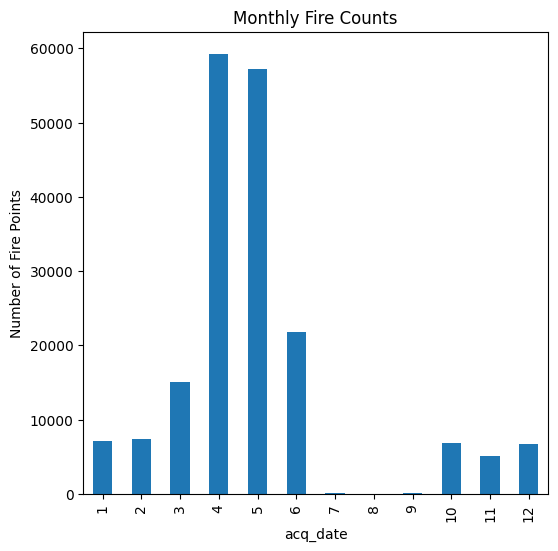

In [ ]:
############ Soil Moisture Plot ################
# Calculate the monthly average soil moisture
monthly_soil_moisture = soil_moisture.groupby('month')['soil_moisture'].mean()

# Plot the monthly time series
monthly_soil_moisture.plot(kind='line', title='Average Soil Moisture Over Months', ylabel='Soil Moisture', figsize=(6, 6))
plt.show()

############ Fire Points Plot ################
# Convert 'acq_date' to datetime format
fire_points['acq_date'] = pd.to_datetime(fire_points['acq_date'])

# Group by month
monthly_fire_counts = fire_points.groupby(fire_points['acq_date'].dt.month).size()

# Plot the fir epoints counts
monthly_fire_counts.plot(kind='bar', title='Monthly Fire Counts', ylabel='Number of Fire Points', figsize=(6, 6))
plt.show()

The graphs clearly show that fire points are at their lowest when soil moisture is at its highest (month 8), and conversely, fire points increase when soil moisture is at its lowest (month 4).

#### 4) Spatial Analysis

In [ ]:
# Function to parse the GeoJSON-like string and extract only the geometry
def parse_geojson(geojson_str):
    # Convert the string to a Python dictionary
    geo_dict = json.loads(geojson_str)
    # Extract the geometry (type and coordinates)
    geometry = {
        'type': geo_dict['type'],
        'coordinates': geo_dict['coordinates']
    }
    return geometry

# Apply the function to parse the 'geo' column
soil_moisture['geometry'] = soil_moisture['.geo'].apply(parse_geojson)

# Convert the parsed 'geometry' column to actual geometries using Shapely
soil_moisture['geometry'] = soil_moisture['geometry'].apply(lambda x: shape(x))  # Convert to Shapely geometry

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(soil_moisture, geometry='geometry')

gdf.head()

system:index       date  \
0  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
1  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
2  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
3  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
4  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   

   soil_moisture                                               .geo  \
0     -11.933647  {"geodesic":false,"type":"Point","coordinates"...   
1     -13.786270  {"geodesic":false,"type":"Point","coordinates"...   
2     -13.974002  {"geodesic":false,"type":"Point","coordinates"...   
3     -13.385861  {"geodesic":false,"type":"Point","coordinates"...   
4     -14.568831  {"geodesic":false,"type":"Point","coordinates"...   

                    geometry  
0  POINT (80.09114 29.09904)  
1  POINT (80.10141 29.09911)  
2  POINT (80.11169 29.09918)  
3  POINT (80.12197 29.09925)  
4  POINT (80.13224 29.09931)

In [ ]:
gdf = gdf.set_crs(epsg=4326)

Filtering out invalid geometries in a GeoDataFrame:

In [ ]:
gdf = gdf[gdf.is_valid]  #Filtering out the invalid geometries from the gdf

In [ ]:
gdf.shape

(3761426, 6)

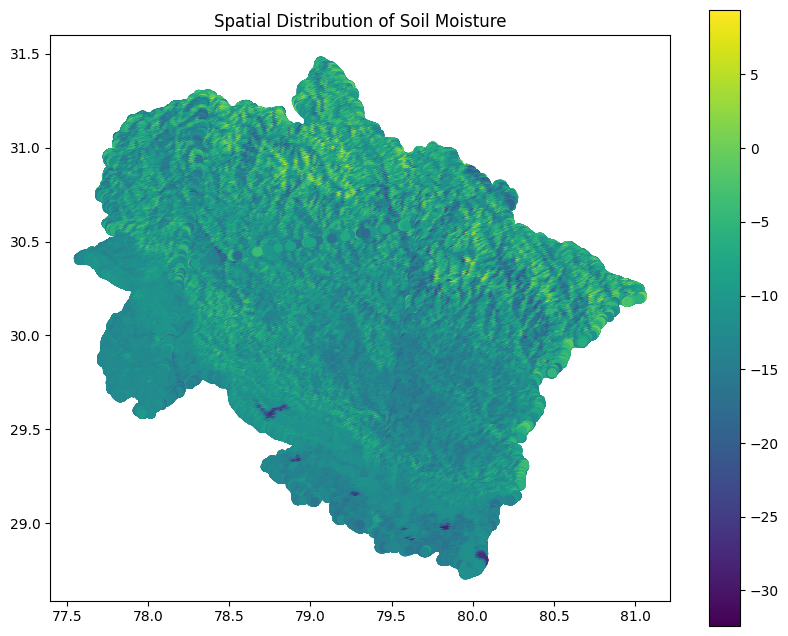

In [ ]:
# Create the plot
gdf.plot(column='soil_moisture', cmap='viridis', legend=True, figsize=(10, 8))
plt.title('Spatial Distribution of Soil Moisture')
plt.show()

#### 5) Spatial Analysis by District

###### Loading district data & spatial join

In [ ]:
# Load the district shapefile
districts_gdf = gpd.read_file("/content/drive/My Drive/Uttarakhand Districts/uttarakhand_districts.shp")
districts_gdf.head()

District        STATE REMARKS  State_LGD DISTRICT_L     Shape_Leng  \
0     ALMORA  UTTARAKHAND    None          5         45  394957.247649   
1  BAGESHWAR  UTTARAKHAND    None          5         46  315673.159842   
2  CHAMPAWAT  UTTARAKHAND    None          5         48  271591.235892   
3   DEHRADUN  UTTARAKHAND    None          5         49  503253.164310   
4   HARIDWAR  UTTARAKHAND    None          5         50  287340.472634   

     Shape_Area                                           geometry  
0  3.054452e+09  POLYGON ((79.47164 29.97947, 79.47276 29.97971...  
1  2.173076e+09  POLYGON ((79.89399 29.71221, 79.89046 29.71247...  
2  1.715187e+09  POLYGON ((80.24243 29.44379, 80.24233 29.44341...  
3  3.019033e+09  POLYGON ((77.82982 31.02876, 77.83141 31.02872...  
4  2.225505e+09  POLYGON ((78.20209 29.9661, 78.20211 29.9661, ...

In [ ]:
# Perform spatial join
soil_moisture_with_districts = gpd.sjoin(gdf, districts_gdf, how="inner", predicate="within")

# View the result
soil_moisture_with_districts.head()

system:index       date  \
0  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
1  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
2  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
3  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   
4  S1A_IW_GRDH_1SDV_20240102T123906_20240102T1239... 2024-01-02   

   soil_moisture                                               .geo  \
0     -11.933647  {"geodesic":false,"type":"Point","coordinates"...   
1     -13.786270  {"geodesic":false,"type":"Point","coordinates"...   
2     -13.974002  {"geodesic":false,"type":"Point","coordinates"...   
3     -13.385861  {"geodesic":false,"type":"Point","coordinates"...   
4     -14.568831  {"geodesic":false,"type":"Point","coordinates"...   

                    geometry  index_right   District        STATE REMARKS  \
0  POINT (80.09114 29.09904)            2  CHAMPAWAT  UTTARAKHAND    None   
1  POINT (80.10141 29.09911)            2  CHAMPAWAT  UTTARAKHAND    None   
2  POINT (80.11169 29.09918)            2  CHAMPAWAT  UTTARAKHAND    None   
3  POINT (80.12197 29.09925)            2  CHAMPAWAT  UTTARAKHAND    None   
4  POINT (80.13224 29.09931)            2  CHAMPAWAT  UTTARAKHAND    None   

   State_LGD DISTRICT_L     Shape_Leng    Shape_Area  
0          5         48  271591.235892  1.715187e+09  
1          5         48  271591.235892  1.715187e+09  
2          5         48  271591.235892  1.715187e+09  
3          5         48  271591.235892  1.715187e+09  
4          5         48  271591.235892  1.715187e+09

 ###### Average Soil Moisture per District:

         District  soil_moisture
2         CHAMOLI      -9.782469
9     RUDRAPRAYAG      -9.895611
12     UTTARKASHI      -9.924766
8     PITHORAGARH     -10.014683
10  TEHRI GARHWAL     -10.063566


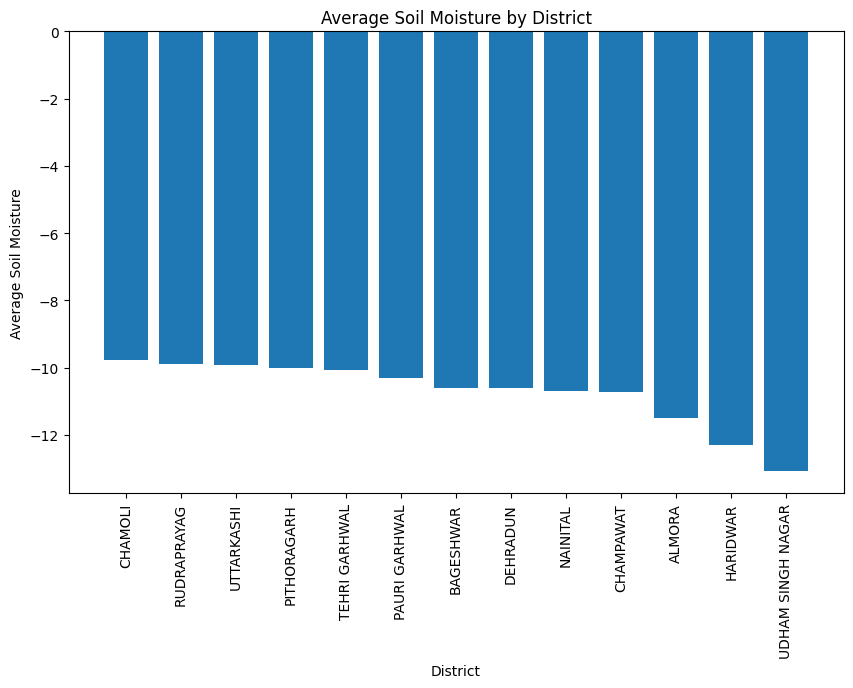

In [ ]:
# Calculate average soil moisture per district
average_soil_moisture_by_district = soil_moisture_with_districts.groupby('District')['soil_moisture'].mean().reset_index()

# Sort the results by soil moisture values
average_soil_moisture_by_district = average_soil_moisture_by_district.sort_values(by='soil_moisture', ascending=False)

# View the result
print(average_soil_moisture_by_district.head())

# Bar plot of average soil moisture by district
plt.figure(figsize=(10, 6))
plt.bar(average_soil_moisture_by_district['District'], average_soil_moisture_by_district['soil_moisture'])
plt.title('Average Soil Moisture by District')
plt.xlabel('District')
plt.xticks(rotation=90)
plt.ylabel('Average Soil Moisture')
plt.show()

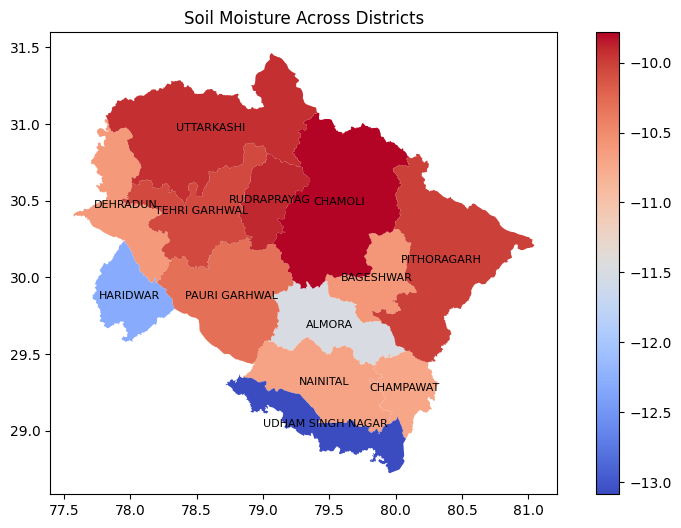

In [ ]:
# Merge the average soil moisture with the district geometries
districts_with_soil_moisture = districts_gdf.merge(average_soil_moisture_by_district, on='District')

fig, ax = plt.subplots(figsize=(10, 6))
districts_with_soil_moisture.plot(column='soil_moisture', cmap='coolwarm', legend=True, ax=ax)

# Add district names
for _, row in districts_with_soil_moisture.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['District'], fontsize=8, ha='center', va='center', color='black')

plt.title('Soil Moisture Across Districts')

plt.show()


**Key Observations:** Udham Singh Nagar and Haridwar are districts with highest soil moisture. On the other hand, Chamoli, Rudraprayag, and Uttarkashi have the highest soil moisture.

###### Monthly soil moisture by district

In [ ]:
# Convert acq_date to datetime
soil_moisture_with_districts['date'] = pd.to_datetime(soil_moisture_with_districts['date'])

In [ ]:
soil_moisture_with_districts['year_month'] = soil_moisture_with_districts['date'].dt.to_period('M')

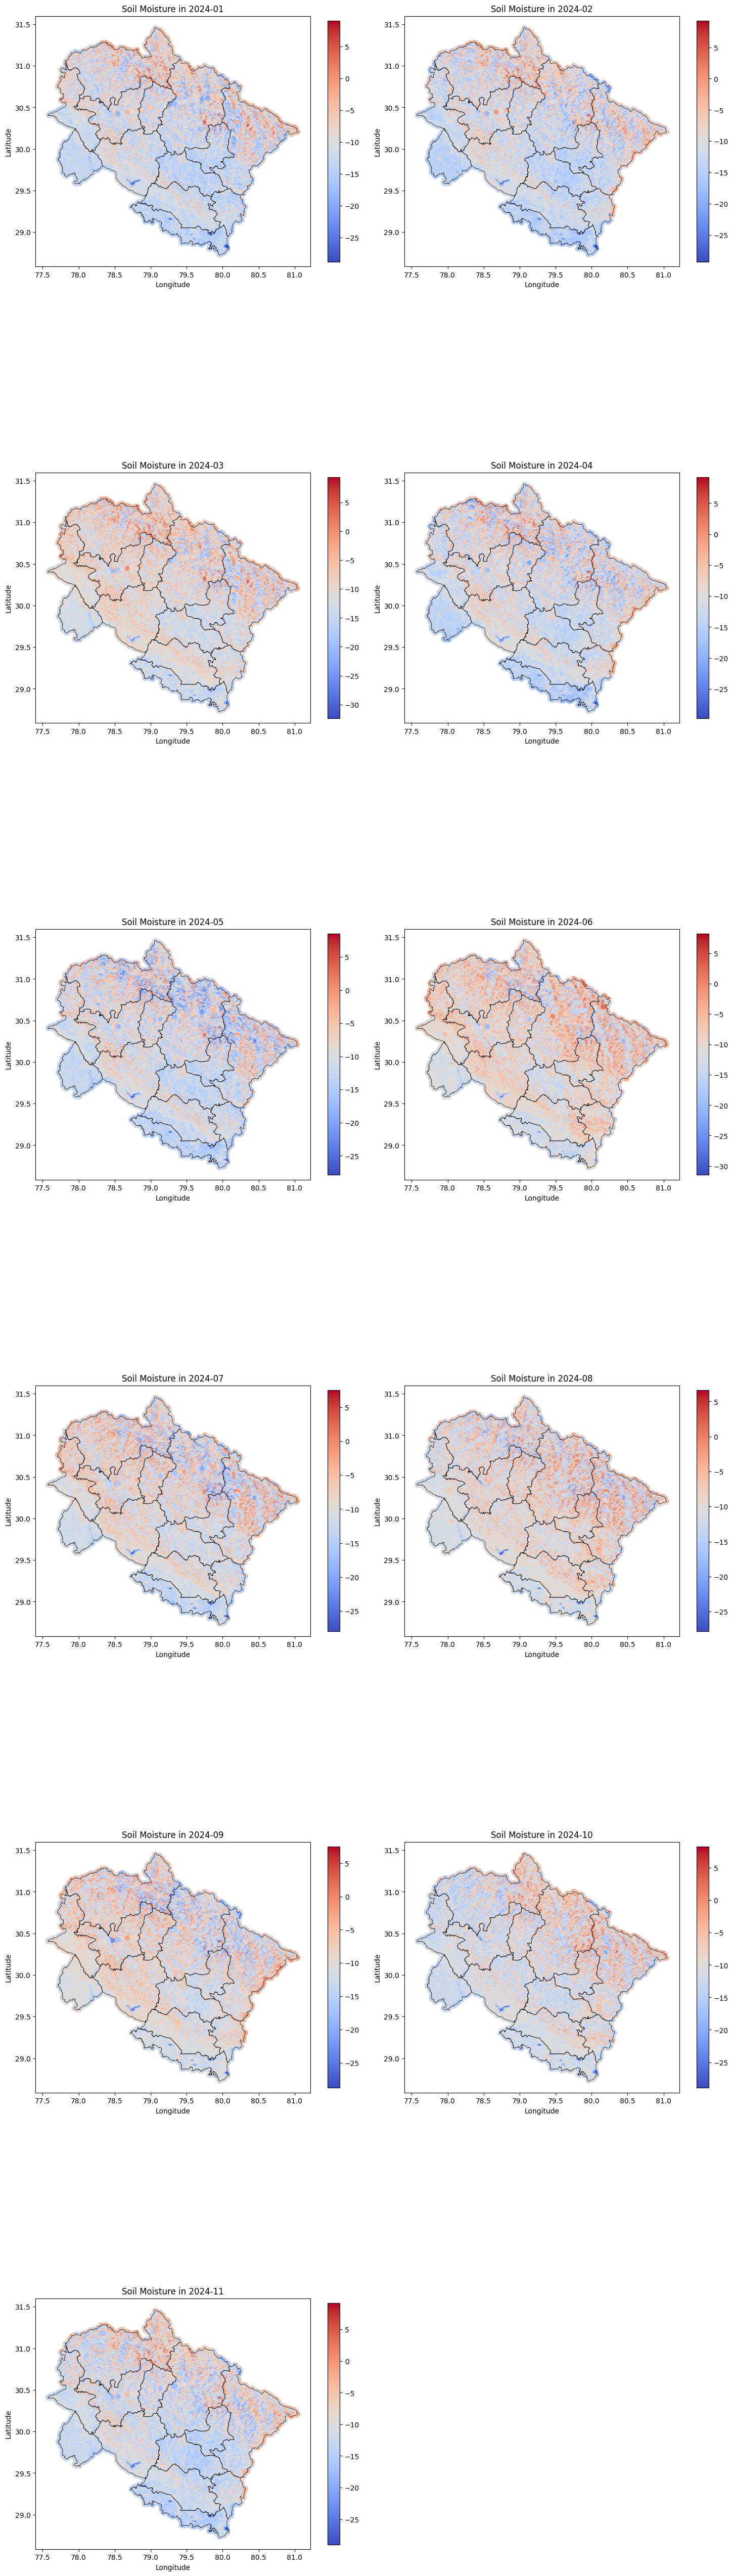

In [ ]:
# Get unique months from the 'year_month' column
unique_months = soil_moisture_with_districts['year_month'].unique()

# Create subplots for each month
fig, axes = plt.subplots(
    nrows=len(unique_months) // 2 + len(unique_months) % 2,
    ncols=2,
    figsize=(15, len(unique_months) * 5)
)

# Flatten the axes array
axes = axes.flatten()

# Loop through each unique month
for idx, month in enumerate(unique_months):
    ax = axes[idx]

    # Filter data for the current month
    monthly_soil_moisture_for_month = soil_moisture_with_districts[soil_moisture_with_districts['year_month'] == month]

    # Plot districts as the base map
    districts_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

    # Plot the soil moisture data for the current month on top
    monthly_soil_moisture_for_month.plot(ax=ax, column='soil_moisture', cmap='coolwarm', legend=True, legend_kwds={'shrink': 0.5})

    # Set title and labels
    ax.set_title(f"Soil Moisture in {month}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Remove unused subplots if there are any
for i in range(len(unique_months), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


**Key Observations:**

*- Spatial Patterns*

Soil moisture is consistently highest in the districts of Chamoli, Rudraprayag, and Uttarkashi.
Soil moisture is consistently lowest in the districts of Udham Singh Nagar and Haridwar.

*- Seasonal Trends:*

Soil moisture levels increase across all districts during (June, July, August, and September).
Despite seasonal fluctuations, the relative patterns remain consistent, with the districts having the highest and lowest soil moisture retaining their positions.

#### 6) Spatial Analysis by districts & Fire Points

In [ ]:
geometry = [Point(xy) for xy in zip(fire_points['longitude'], fire_points['latitude'])]
fire_gdf = gpd.GeoDataFrame(fire_points, geometry=geometry, crs="EPSG:4326")

# Perform spatial join
fires_with_districts = gpd.sjoin(fire_gdf, districts_gdf, how="left", predicate="intersects")

In [ ]:
# Ensure 'acq_date' is in datetime format
fire_gdf['acq_date'] = pd.to_datetime(fire_gdf['acq_date'])

# Filter for the year 2024 since soil moisture is over 2024
fire_points_2024 = fire_gdf[fire_gdf['acq_date'].dt.year == 2024]

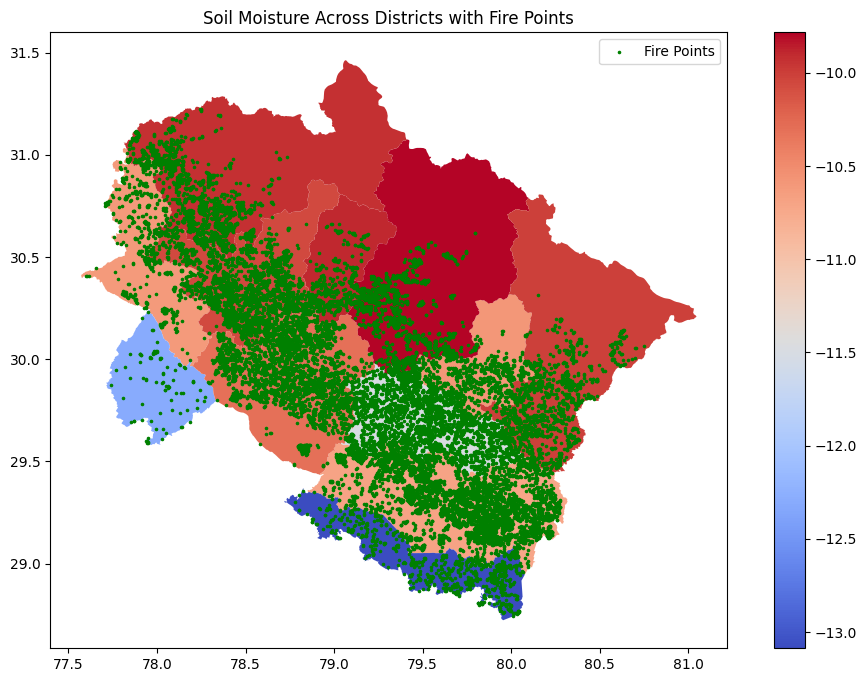

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the districts with soil moisture
districts_with_soil_moisture.plot(
    column='soil_moisture',
    cmap='coolwarm',
    legend=True,
    ax=ax
)

# Plot the fire points
fire_points_2024.plot(
    ax=ax,
    color='green',
    marker='.',
    markersize=10,
    label='Fire Points'
)

ax.legend(loc='upper right')
plt.title('Soil Moisture Across Districts with Fire Points')
plt.show()


**Key Observations**: There is a noticeable lack of fire points in districts with high soil moisture, reinforcing the idea that fires tend to occur in areas with low soil moisture.

###### Number of fire points by districts (Taken from Active_fire_points_EDA)

             District  fire_count
0              ALMORA       22838
1           BAGESHWAR        8229
2             CHAMOLI       11378
3           CHAMPAWAT       10913
4            DEHRADUN        6797
5            HARIDWAR        4575
6            NAINITAL       24648
7       PAURI GARHWAL       32936
8         PITHORAGARH        9858
9         RUDRAPRAYAG        4786
10      TEHRI GARHWAL       19423
11  UDHAM SINGH NAGAR       16856
12         UTTARKASHI       13477


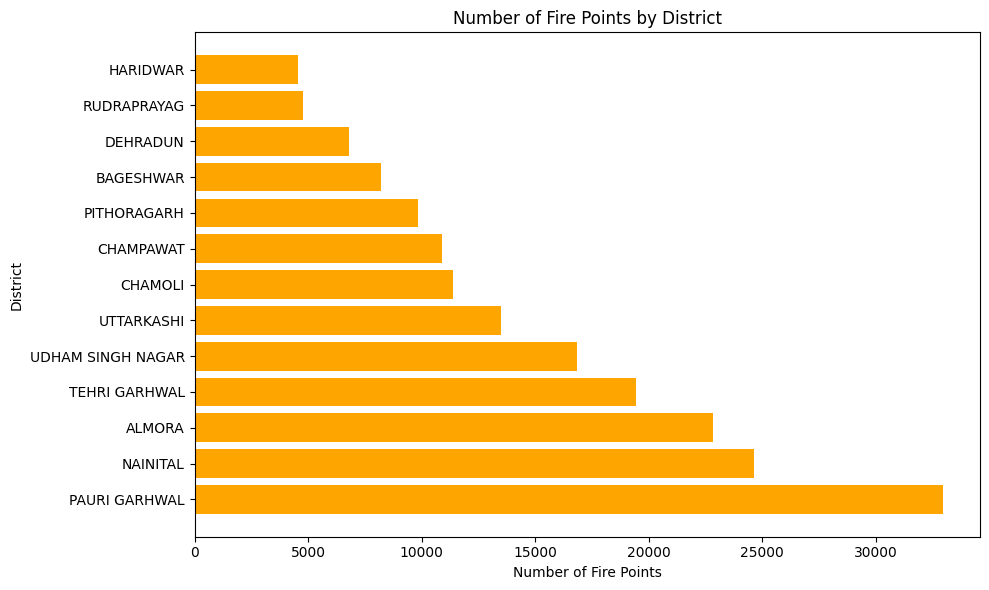

In [ ]:
# Group by district name and count fire points
fires_by_district = fires_with_districts.groupby("District").size().reset_index(name="fire_count")
print(fires_by_district)

# Plot fire count by district
fires_by_district = fires_by_district.sort_values(by="fire_count", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fires_by_district["District"], fires_by_district["fire_count"], color="orange")
plt.title("Number of Fire Points by District")
plt.xlabel("Number of Fire Points")
plt.ylabel("District")
plt.tight_layout()
plt.show()


###### Comparison of Average Soil Moisture and Fire Count Across Districts

<ipython-input-37-a1b405d8c9f6>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_data["District"], rotation=90)


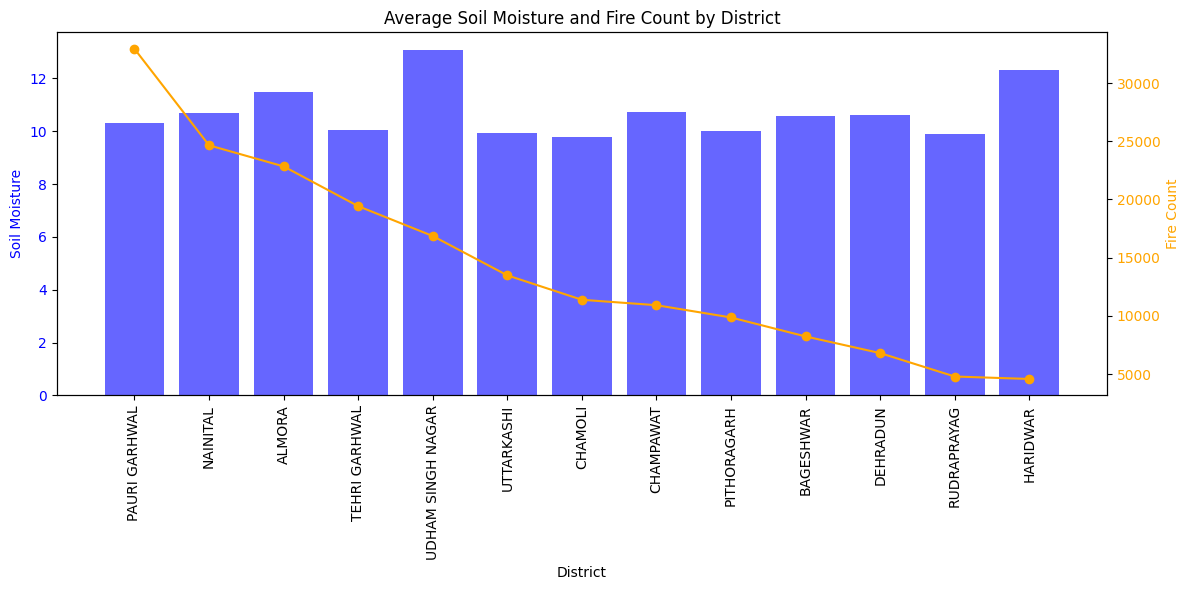

In [ ]:
# Merge the two datasets on District
combined_data = pd.merge(
    average_soil_moisture_by_district,
    fires_by_district,
    on="District",
    how="inner"
)
combined_data["soil_moisture"] = combined_data["soil_moisture"].abs()


# Sort the combined data by fire count or soil moisture for consistent ordering
combined_data = combined_data.sort_values(by="fire_count", ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average soil moisture
ax1.bar(combined_data["District"], combined_data["soil_moisture"], color="blue", alpha=0.6, label="Average Soil Moisture")
ax1.set_xlabel("District")
ax1.set_ylabel("Soil Moisture", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticklabels(combined_data["District"], rotation=90)

# Create a second y-axis for fire counts
ax2 = ax1.twinx()
ax2.plot(combined_data["District"], combined_data["fire_count"], color="orange", marker="o", label="Fire Count")
ax2.set_ylabel("Fire Count", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# Titles and layout
plt.title("Average Soil Moisture and Fire Count by District")
fig.tight_layout()

# Show plot
plt.show()


<ipython-input-38-354c795b5adc>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_data["District"], rotation=90)


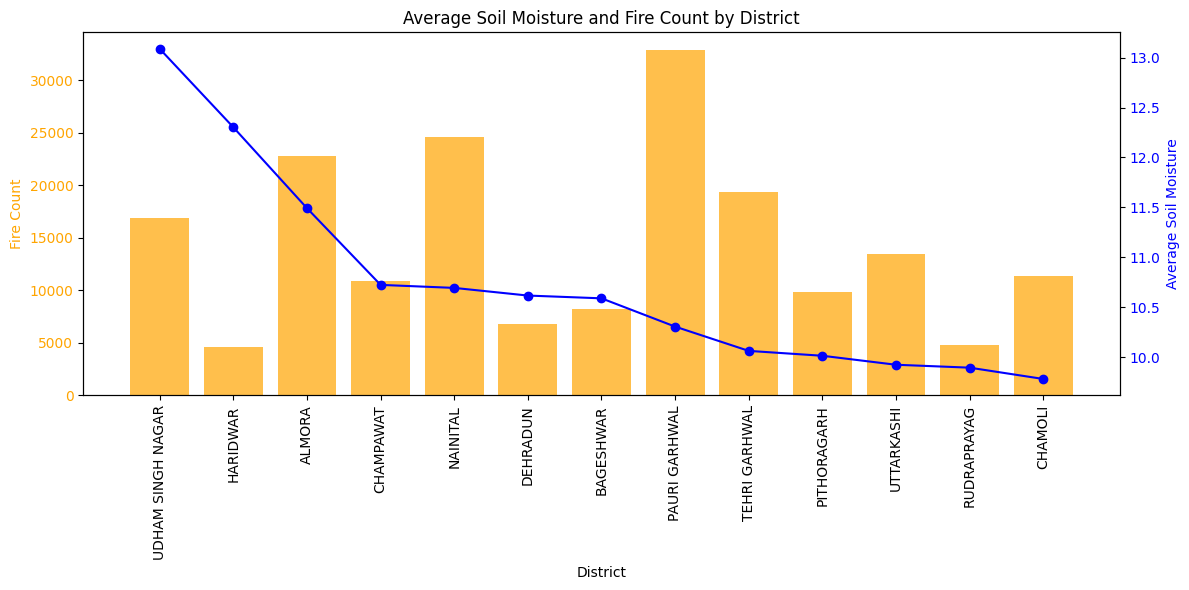

In [ ]:
combined_data = combined_data.sort_values(by="soil_moisture", ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot fire counts
ax1.bar(combined_data["District"], combined_data["fire_count"], color="orange", alpha=0.7, label="Fire Count")
ax1.set_ylabel("Fire Count", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")
ax1.set_xlabel("District")

# Plot soil moisture on secondary axis
ax2 = ax1.twinx()
ax2.plot(combined_data["District"], combined_data["soil_moisture"], color="blue", marker="o", label="Average Soil Moisture")
ax2.set_ylabel("Average Soil Moisture", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Title and adjustments
plt.title("Average Soil Moisture and Fire Count by District")
ax1.set_xticklabels(combined_data["District"], rotation=90)
plt.tight_layout()
plt.show()


**Key Observations:** The graphs further highlight the negative correlation where lower soil moisture increases fire risk with districts like Pauri Garhwal exhibiting low soil moisture and high fire counts, while Haridwar shows the opposite trend.